<a href="https://colab.research.google.com/github/durg3sh10/Classifying-buildings-Post-Hurricane-using-Satellite-Imagery/blob/main/Durgesh_Hurricane.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Problem Statement:** Classifying buildings Post Hurricane using Satellite Imagery

#### Damage assessment is crucial for emergency managers to respond quickly and allocate resources after a hurricane. The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. Quantifying the number of flooded/damaged structures, which is generally done via ground survey, is one technique to measure the magnitude of the damage. This procedure can be time-consuming and labor-intensive. 

####In this project, we suggest using image classification algorithms on post-hurricane satellite photos to improve the efficiency of building damage assessment. Each square-sized image contains a structure that can be rated as 'Damaged' (as determined by volunteers in a crowd-sourcing initiative) or 'Undamaged'.

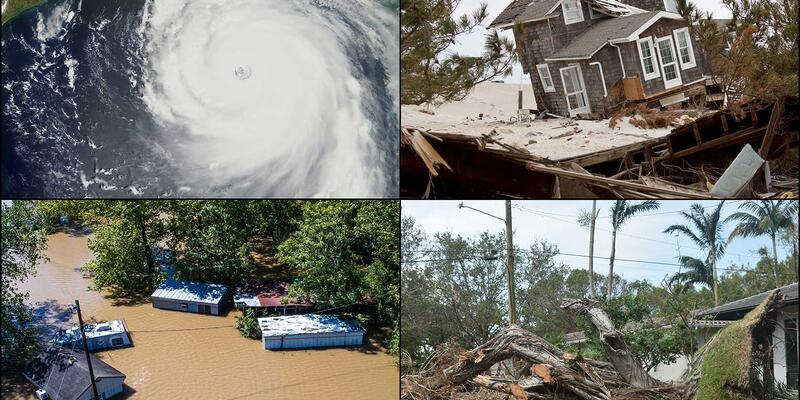

The data provided in the following subfolders as follows:

* train_another: the training data; 5000 images of each class(damage/no damage)

* validation_another: the validation data; 1000 images of each class(damage/no damage)

* test_another: the unbalanced test data; 8000/1000 images of damaged/undamaged classes

* test: the balanced test data; 1000 images of each class(damage/no damage)


####Note this is satellite imagery as well, but the images are not specifically of buildings but also of water bodies and land.

**Importing the required libraries:**

To start with, we have imported all the necessary libraries for this analysis



In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import expand_dims
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from tensorflow.keras.callbacks import TensorBoard

import h5py
import PIL.Image
import io
import requests
from PIL import Image

sns.set_style("whitegrid")
print(tf.__version__)

2.8.0


In [4]:
tensorboard = TensorBoard(log_dir = "/content/drive/MyDrive/Data science/Dataset/hurricane/tenserboard", update_freq = "epoch")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Image Prepocessing

It's difficult to know how to prepare images for modelling, such as scaling or normalising pixel values, when using convolutional neural networks for image categorization.

Additionally, picture data augmentation and test-time augmentation can be utilised to improve a fit model's predictive performance and reduce generalisation error.

Rather of guessing what could work, examine the forms of data preparation, train-time augmentation, and test-time augmentation employed on models available.

In [5]:
#os.remove('/content/drive/MyDrive/Data science/Data/Huricance/archive.zip')
#shutil.rmtree('/content/drive/MyDrive/Data science/Data/Huricance', ignore_errors=True)
os.chdir("/content/drive/MyDrive/Data science/Dataset/hurricane/")
print(os.getcwd())
print(os.listdir())

/content/drive/MyDrive/Data science/Dataset/hurricane
['test', 'test_another', 'train_another', 'validation_another', 'Checkpoint', 'save_model', 'tenserboard', '.ipynb_checkpoints']


In [5]:
## For extracting the dataset folder

# from zipfile import ZipFile as zip2
# with zip2("/content/drive/MyDrive/Hurricane/archive.zip", 'r') as zip1:
#     # printing all the contents of the zip file
#     zip1.printdir()
  
#     # extracting all the files
#     print('Extracting all the files now...')
#     zip1.extractall()
#     print('Done!')

In [6]:
damage_train = os.listdir("train_another/damage")
nodamage_train = os.listdir("train_another/no_damage")
print("damage_train & no damage_train is ", len(damage_train), len(nodamage_train))

damage_balanced_test = os.listdir("test/damage")
nodamage_balanced_test = os.listdir("test/no_damage")
print("damage_test & no damage_test is ", len(damage_balanced_test), len(nodamage_balanced_test))

damage_unbalanced_test = os.listdir("test_another/damage")
nodamage_unbalanced_test = os.listdir("test_another/no_damage")
print("damage_test & no damage_test is ", len(damage_unbalanced_test), len(nodamage_unbalanced_test))

damage_val = os.listdir("validation_another/damage")
nodamage_val = os.listdir("validation_another/no_damage")
print("damage_valv & no damage_valv is ", len(damage_val), len(nodamage_val))

damage_train & no damage_train is  5000 5000
damage_test & no damage_test is  1000 1000
damage_test & no damage_test is  8000 1000
damage_valv & no damage_valv is  1000 1000


##Data augmentaion:

Data augmentation is a method of altering original images by applying various transformations to them, resulting in many altered copies of the same image. However, depending on the augmentation techniques you use, such as shifting, rotating, and flipping, each copy is unique in some ways.

The original photograph's target class is not changed by making these tiny alterations; rather, it provides a new perspective on capturing the object in real life. As a result, we use it frequently in the creation of deep learning models.

That is, it creates augmented images on the fly while your model is still being trained. What a fantastic idea!
At each epoch, the ImageDataGenerator class guarantees that the model receives new variations of the images. However, it merely returns the altered photos and does not include them in the original corpus.

In [11]:
#Giving the directory path
train_directory = "/content/drive/MyDrive/Data science/Dataset/hurricane/train_another"
val_directory = "/content/drive/MyDrive/Data science/Dataset/hurricane/validation_another"
test_directory_balanced  = "/content/drive/MyDrive/Data science/Dataset/hurricane/test"
test_directory_unbalanced = "/content/drive/MyDrive/Data science/Dataset/hurricane/test_another"


from keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
datagen = ImageDataGenerator(rotation_range=40, width_shift_range=0.2, 
                             height_shift_range=0.2, shear_range=0.2, 
                             zoom_range=0.2, rescale=1/255, 
                             vertical_flip = True, horizontal_flip=True)

train_batches = datagen.flow_from_directory(directory = train_directory, target_size=(150,150),
                                                        batch_size=32, 
                                                       class_mode = "binary")

val_batches = datagen.flow_from_directory(directory = val_directory, target_size=(150,150),
                                                       batch_size=32, 
                                                       class_mode = "binary")
test_balanced_batches = datagen.flow_from_directory(directory = test_directory_balanced, target_size=(150,150),
                                                       batch_size=32, 
                                                       class_mode = "binary")

test_unbalanced_batches = datagen.flow_from_directory(directory = test_directory_unbalanced, target_size=(150,150),
                                                       batch_size=32, 
                                                       class_mode = "binary")

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.


Class indices {'damage': 0, 'no_damage': 1}
[0. 1. 1. 1. 0.]


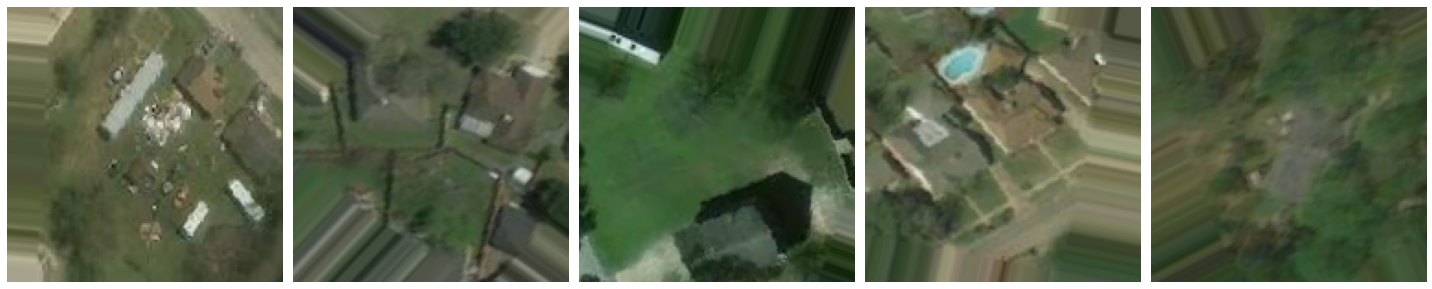

In [8]:
# Showing first 5 images from the train data
img, labels = next(train_batches)
print("Class indices",train_batches.class_indices)
print(labels[:5])
def plotImages(images_arr, labels):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plotImages(img, labels)

In [26]:
# Initialize the 1st sequential model
model = Sequential(name="CNN")

# First convolution layer, Batch Normalization, MaxPooling
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(150,150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))

# Second convolution layer, Batch Normalization, MaxPooling
model.add(Conv2D(64, (3,3), activation="relu", kernel_initializer="he_uniform",padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))


# Flatten layer
model.add(Flatten())

# Fully connected dense layer
model.add(Dense(128, activation="relu", kernel_initializer="he_uniform"))
model.add(BatchNormalization())

# Output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 batch_normalization_6 (Batc  (None, 150, 150, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_7 (Batc  (None, 75, 75, 64)       256       
 hNormalization)                                                 
                                                               

In [10]:
# Compile the model
model.compile(optimizer=Adam(0.01), loss="binary_crossentropy", metrics=['accuracy']) 

# Using callback in keras
callback = tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss',restore_best_weights=True)

# Fit the model
CNN_history = model.fit(train_batches, epochs=20, shuffle=False, validation_data=val_batches, callbacks=[callback, tensorboard],verbose=1)

Epoch 1/20
313/313 [==============================] - 2220s 7s/step - loss: 0.3324 - accuracy: 0.8651 - val_loss: 1.4911 - val_accuracy: 0.5025
Epoch 2/20
313/313 [==============================] - 79s 254ms/step - loss: 0.2331 - accuracy: 0.9055 - val_loss: 0.5313 - val_accuracy: 0.8355
Epoch 3/20
313/313 [==============================] - 80s 255ms/step - loss: 0.2088 - accuracy: 0.9175 - val_loss: 1.1944 - val_accuracy: 0.5535
Epoch 4/20
313/313 [==============================] - 80s 254ms/step - loss: 0.2058 - accuracy: 0.9176 - val_loss: 0.7507 - val_accuracy: 0.7810
Epoch 5/20
313/313 [==============================] - 80s 255ms/step - loss: 0.1843 - accuracy: 0.9302 - val_loss: 1.1413 - val_accuracy: 0.6455
Epoch 6/20
313/313 [==============================] - 81s 259ms/step - loss: 0.1942 - accuracy: 0.9235 - val_loss: 1.4783 - val_accuracy: 0.6065
Epoch 7/20
313/313 [==============================] - 81s 260ms/step - loss: 0.1711 - accuracy: 0.9336 - val_loss: 0.3691 - val_acc

In [8]:
filepath = "/content/drive/MyDrive/Data science/Dataset/hurricane/save_model"
model.save(filepath)

In [9]:
filepath = "/content/drive/MyDrive/Data science/Dataset/hurricane/save_model"
from keras.models import load_model
model = load_model(filepath)

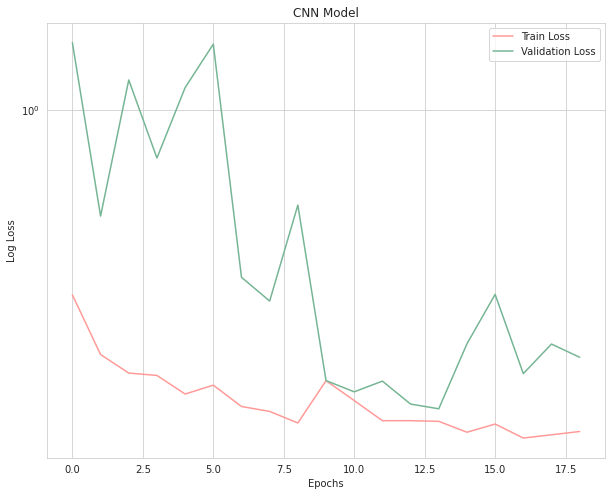

In [13]:
# Ploting the Loss of the model
plt.rcParams["figure.figsize"] = (10,8)
plt.title("CNN Model")
plt.semilogy(CNN_history.history['loss'], label='Train Loss', color='#FF9A98')
plt.semilogy(CNN_history.history['val_loss'],  label='Validation Loss', color='#75B594')
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.legend()
plt.show()

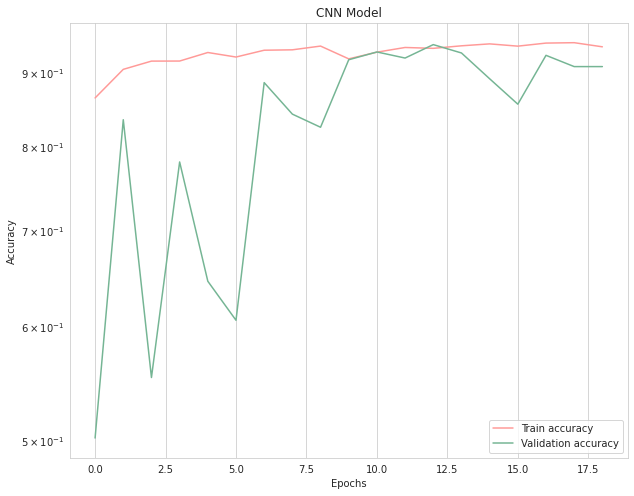

In [14]:
# Ploting the accuracy of the model
plt.rcParams["figure.figsize"] = (10,8)
plt.title("CNN Model")
plt.semilogy(CNN_history.history['accuracy'], label='Train accuracy', color='#FF9A98')
plt.semilogy(CNN_history.history['val_accuracy'],  label='Validation accuracy', color='#75B594')
plt.legend()

# Set the axes labels
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# %load_ext tensorboard
# %tensorboard --logdir=log_dir

In [16]:
#test_balanced_pred = model.evaluate(test_balanced_batches)
test_unbalanced_pred = model.evaluate(test_unbalanced_batches)
print(test_unbalanced_pred)

282/282 [==============================] - 2568s 9s/step - loss: 0.1029 - accuracy: 0.9622
[0.10287401080131531, 0.9622222185134888]


In [12]:
test_balanced_pred = model.evaluate(test_balanced_batches)
print(test_balanced_pred)

63/63 [==============================] - 223s 3s/step - loss: 0.2013 - accuracy: 0.9160
[0.2012905329465866, 0.9159579873085022]
